This script use kirita data to annotate the raw count from cell ranger

1. PopV integration

- Initial Date: 12/8/2025

In [1]:
# Set 'Liberation Sans' as the default font
from matplotlib import rcParams
rcParams['font.family'] = 'Liberation Sans'

In [2]:
#!/usr/bin/env python
"""
Standard Scanpy Analysis Pipeline for D0_1 and D3_1 samples
Following: https://scanpy.readthedocs.io/en/stable/tutorials/basics/clustering.html

No integration step - just standard preprocessing, QC, normalization, 
dimensionality reduction, and clustering.
"""

import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import os

# Set scanpy settings
sc.settings.set_figure_params(dpi=200, facecolor='white', figsize=(6, 5))
sc.settings.verbosity = 3

# =============================================================================
# CONFIGURATION - Update these paths
# =============================================================================
# Input: Combined h5ad file with D0_1 and D3_1 samples
INPUT_H5AD = "/home/data3/dianli/projects/kenji_rhabdo_2025/processed_data/raw_count_cellranger.h5ad"

ref_H5AD = "/home/data3/dianli/projects/kenji_rhabdo_2025/processed_data/kirita_126578_cell_raw_count.h5ad"
# Output directory
MODEL_OUTPUT_DIR = "/home/data3/dianli/projects/kenji_rhabdo_2025/processed_data/analysis_models/raw_count/label_transfer/popv/"
os.makedirs(MODEL_OUTPUT_DIR, exist_ok=True)

# Sample column name
SAMPLE_COL = "sample"  # or "sample" depending on your data

# Samples to subset
SAMPLES_TO_USE = ["D0_1", "D3_1"]

# =============================================================================
# 1. LOAD DATA AND SUBSET TO D0_1 AND D3_1
# =============================================================================
print("=" * 60)
print("1. LOADING AND SUBSETTING DATA")
print("=" * 60)

# Load the query adata
adata_query = sc.read_h5ad(INPUT_H5AD)
print(f"Loaded adata: {adata_query.shape[0]} cells x {adata_query.shape[1]} genes")

# Load the ref adata
adata_ref = sc.read_h5ad(ref_H5AD)
print(f"Loaded adata: {adata_ref.shape[0]} cells x {adata_ref.shape[1]} genes")

# 1. Ensure your data is loaded (example placeholders)
# adata_query = sc.read("query_data.h5ad")
# adata_ref = sc.read("reference_data.h5ad")

1. LOADING AND SUBSETTING DATA
Loaded adata: 17357 cells x 32285 genes
Loaded adata: 126578 cells x 27133 genes


In [3]:
import scanpy as sc
import popv
from popv.preprocessing import Process_Query
from popv.annotation import annotate_data
from datetime import datetime

# =============================================================================
# 2. Map your cell type labels to Cell Ontology terms
# =============================================================================
# Customize this mapping based on your reference labels
# label_mapping = {
#     # Proximal tubule segments
#     "PT": "epithelial cell of proximal tubule",
#     "PT-S1": "epithelial cell of proximal tubule",
#     "PT-S2": "epithelial cell of proximal tubule",
#     "PT-S3": "epithelial cell of proximal tubule",
#     "PTS1": "epithelial cell of proximal tubule",
#     "PTS2": "epithelial cell of proximal tubule",
#     "PTS3": "epithelial cell of proximal tubule",
#     "PCT": "epithelial cell of proximal tubule",
#     "PST": "epithelial cell of proximal tubule",
    
#     # Loop of Henle
#     "DTL": "kidney loop of Henle thin descending limb epithelial cell",
#     "ATL": "kidney loop of Henle thin ascending limb epithelial cell",
#     "TAL": "kidney loop of Henle thick ascending limb epithelial cell",
#     "tAL": "kidney loop of Henle thin ascending limb epithelial cell",
#     "LOH": "kidney loop of Henle epithelial cell",
    
#     # Distal nephron
#     "DCT": "kidney distal convoluted tubule epithelial cell",
#     "CNT": "kidney connecting tubule epithelial cell",
#     "PC": "renal principal cell",
#     "IC": "renal intercalated cell",
#     "IC-A": "renal intercalated cell",
#     "IC-B": "renal intercalated cell",
#     "CD": "kidney collecting duct epithelial cell",
    
#     # Glomerular
#     "POD": "glomerular visceral epithelial cell",
#     "Podocyte": "glomerular visceral epithelial cell",
#     "PEC": "parietal epithelial cell",
#     "EC-GC": "glomerular endothelial cell",
#     "Mesangial": "mesangial cell",
    
#     # Endothelial subtypes
#     "EC": "endothelial cell",
#     "EC-AEA": "endothelial cell",
#     "EC-DVR": "endothelial cell",
#     "EC-AVR": "endothelial cell",
#     "EC-PTC": "endothelial cell",
#     "EC-LYM": "lymphatic endothelial cell",
    
#     # Stromal
#     "FIB": "fibroblast",
#     "Fibroblast": "fibroblast",
#     "Myofibroblast": "myofibroblast",
#     "vSMC": "vascular associated smooth muscle cell",
#     "Pericyte": "pericyte",
    
#     # Immune
#     "Macrophage": "macrophage",
#     "MAC": "macrophage",
#     "Monocyte": "monocyte",
#     "T cell": "T cell",
#     "NK": "natural killer cell",
#     "B cell": "B cell",
#     "Plasma": "plasma cell",
#     "DC": "dendritic cell",
#     "Mast": "mast cell",
#     "Neutrophil": "neutrophil",
# }

# Apply mapping to reference
# adata_ref.obs["cell_ontology_class"] = adata_ref.obs["celltype"].map(label_mapping)

# Check for unmapped labels
# unmapped = adata_ref.obs[adata_ref.obs["cell_ontology_class"].isna()]["celltype"].unique()
# if len(unmapped) > 0:
#     print(f"WARNING: Unmapped labels found: {unmapped}")
#     print("Please add these to label_mapping dictionary above!")
# else:
#     print("All labels successfully mapped to Cell Ontology terms.")

# =============================================================================
# 3. Configure popV settings (optional)
# =============================================================================
popv.settings.compute_embedding = True    # Compute UMAP embeddings
popv.settings.return_probabilities = True # Return certainty scores

# =============================================================================
# 4. Preprocess query and reference data
# =============================================================================
adata = Process_Query(
    query_adata=adata_query,
    ref_adata=adata_ref,
    ref_labels_key="celltype",              # Your cell type column directly
    ref_batch_key="orig.ident",             # Key for batch info in ref (or None)
    query_batch_key=None,                   # Query batch key if applicable
    cl_obo_folder=False,                    # Disable Cell Ontology and OnClass
    prediction_mode="retrain",              # Options: "retrain", "inference", "fast"
    n_samples_per_label=300,                # Subsample reference per cell type
    save_path_trained_models=MODEL_OUTPUT_DIR,
    hvg=4000,
).adata
# adata = Process_Query(
#     adata_query=adata_query,
#     adata_ref=adata_ref,
#     ref_labels_key="cell_ontology_class",  # Use the mapped column
#     ref_batch_key="orig.ident",                  # Key for batch info in ref (or None)
#     query_batch_key=None,                   # Query batch key if applicable
#     cl_obo_folder=True,                     # Use Cell Ontology for OnClass
#     prediction_mode="retrain",              # Options: "retrain", "inference", "fast"
#     n_samples_per_label=300,                # Subsample reference per cell type
#     save_path_trained_models=MODEL_OUTPUT_DIR,     # Where to save trained models
#     hvg=4000,                               # Number of highly variable genes
# ).adata

# =============================================================================
# 5. Run annotation
# =============================================================================
print(datetime.now())

annotate_data(adata)

print(datetime.now())



Loading faiss with AVX512 support.
Successfully loaded faiss with AVX512 support.
2025-12-08 18:30:00.761327: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-08 18:30:00.819331: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-12-08 18:30:01.872553: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`

filtered out 9695 genes that are detected in less than 200 cells
extracting highly variable genes
normalizing counts per cell
    finished (0:00:00)


Sampling 300 cells per label


... be careful when using `max_value` without `zero_center`.
computing PCA
    with n_comps=50
    finished (0:00:04)
normalizing counts per cell
    finished (0:00:00)
2025-12-08 18:30:22.634472


  0%|                                                                                                    | 0/7 [00:00<?, ?it/s]Saving celltypist results to adata.obs["popv_celltypist_prediction"]


computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:41)
running Leiden clustering
    finished: found 309 clusters and added
    'over_clustering', the cluster labels (adata.obs, categorical) (0:06:51)


🍳 Preparing data before training
🔬 Input data has 7655 cells and 4000 genes
⚖️ Scaling input data
🏋️ Training data using mini-batch SGD logistic regression
⚠️ Warning: the number of cells (7655) is not big enough to conduct a proper mini-batch training. You may consider using traditional SGD classifier (mini_batch = False)
⏳ Epochs: [1/10]
⏳ Epochs: [2/10]
⏳ Epochs: [3/10]
⏳ Epochs: [4/10]
⏳ Epochs: [5/10]
⏳ Epochs: [6/10]
⏳ Epochs: [7/10]
⏳ Epochs: [8/10]
⏳ Epochs: [9/10]
⏳ Epochs: [10/10]
✅ Model training done!
🔬 Input data has 143935 cells and 4000 genes
🔗 Matching reference genes in the model
🧬 4000 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
🗳️ Majority voting the predictions
✅ Majority voting done!
 14%|█████████████                                                                              | 1/7 [07:47<46:42, 467.03s/it]Integrating data with bbknn


computing batch balanced neighbors
	finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:01:32)


Saving knn on bbknn results to adata.obs["popv_knn_bbknn_prediction"]
Saving UMAP of BBKNN results to adata.obsm["X_umap_bbknn_popv"]


computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:16)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:02:51)


 29%|██████████████████████████                                                                 | 2/7 [12:30<29:56, 359.29s/it]Integrating data with harmony
2025-12-08 18:42:53,752 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
Computing initial centroids with sklearn.KMeans...
2025-12-08 18:43:35,915 - harmonypy - INFO - sklearn.KMeans initialization complete.
sklearn.KMeans initialization complete.
2025-12-08 18:43:37,361 - harmonypy - INFO - Iteration 1 of 10
Iteration 1 of 10
2025-12-08 18:45:38,499 - harmonypy - INFO - Iteration 2 of 10
Iteration 2 of 10
2025-12-08 18:47:04,351 - harmonypy - INFO - Iteration 3 of 10
Iteration 3 of 10
2025-12-08 18:49:03,718 - harmonypy - INFO - Iteration 4 of 10
Iteration 4 of 10
2025-12-08 18:50:59,817 - harmonypy - INFO - Iteration 5 of 10
Iteration 5 of 10
2025-12-08 18:52:55,961 - harmonypy - INFO - Iteration 6 of 10
Iteration 6 of 10
2025-12-08 18:54:52,161 - harmonypy - INFO - Converged after 6 iterations
Converged a

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:33)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:02:18)


 43%|███████████████████████████████████████                                                    | 3/7 [30:13<45:22, 680.64s/it]Integrating data with scvi
Training scvi offline.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
You are using a CUDA device ('NVIDIA RTX A6000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


Retraining scvi for 28 epochs.


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 28/28: 100%|████████████████████████████████████████████████████| 28/28 [02:06<00:00,  4.42s/it, v_num=1, train_loss=907]

`Trainer.fit` stopped: `max_epochs=28` reached.


Epoch 28/28: 100%|████████████████████████████████████████████████████| 28/28 [02:06<00:00,  4.51s/it, v_num=1, train_loss=907]


Saving knn on scvi results to adata.obs["popv_knn_on_scvi_prediction"]
Saving UMAP of scVI results to adata.obsm["X_umap_scvi_popv"]


computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:18)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:02:36)


 57%|████████████████████████████████████████████████████                                       | 4/7 [36:41<28:15, 565.12s/it]Integrating data with scANVI


INFO     File                                                                                                      
         /home/data3/dianli/projects/kenji_rhabdo_2025/processed_data/analysis_models/raw_count/label_transfer/popv
         /scvi/model.pt already downloaded                                                                         
INFO     Training for 20 epochs.                                                                                   


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 20/20: 100%|████████████████████████████████████████████████████| 20/20 [03:03<00:00,  9.27s/it, v_num=1, train_loss=905]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 20/20: 100%|████████████████████████████████████████████████████| 20/20 [03:03<00:00,  9.20s/it, v_num=1, train_loss=905]


Saving scanvi label prediction to adata.obs["popv_scanvi_prediction"]


INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


Saving UMAP of BBKNN results to adata.obsm["X_umap_scanvi_popv"]


computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:13)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:03:10)


100%|███████████████████████████████████████████████████████████████████████████████████████████| 7/7 [47:51<00:00, 410.20s/it]
Using predictions ['popv_celltypist_prediction', 'popv_knn_bbknn_prediction', 'popv_knn_harmony_prediction', 'popv_knn_on_scvi_prediction', 'popv_scanvi_prediction', 'popv_svm_prediction', 'popv_xgboost_prediction'] for PopV consensus


2025-12-08 19:18:24.998910


In [5]:
adata

AnnData object with n_obs × n_vars = 143935 × 4000
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'rep', 'percent.mito', 'percent.Rpl', 'percent.Rps', 'time', 'seurat_clusters', 'batch.n', 'rep.n', 'S.Score', 'G2M.Score', 'Phase', 'CC.Difference', 'AllIDn1', 'AllIDn2', 'name', 'Replicates', 'celltype', '_batch_annotation', 'n_counts', '_dataset', '_reference_labels_annotation', '_labels_annotation', '_ref_subsample', 'sample', 'in_original', 'percent.mt', 'nCount_SCT', 'nFeature_SCT', 'pANN_0.25_0.26_600', 'DF.classifications_0.25_0.26_600', 'doubletdata', 'nCount_ATAC', 'nFeature_ATAC', 'nucleosome_signal', 'nucleosome_percentile', 'TSS.enrichment', 'TSS.percentile', 'pANN_0.25_0.08_899', 'DF.classifications_0.25_0.08_899', 'nCount_peaks', 'nFeature_peaks', 'nCount_RNA_clean', 'nFeature_RNA_clean', 'old.ident', 'SCT_snn_res.0.8', 'SCT.weight', 'wsnn_res.0.6', 'wsnn_res.0.4', 'nCount_TSSaccessibility', 'nFeature_TSSaccessibility', '_labelled_train_indices', '_predict_cells', 'ove

In [19]:
pd.options.display.max_columns = None
adata.obs

,orig.ident,nCount_RNA,nFeature_RNA,rep,percent.mito,percent.Rpl,percent.Rps,time,seurat_clusters,batch.n,rep.n,S.Score,G2M.Score,Phase,CC.Difference,AllIDn1,AllIDn2,name,Replicates,celltype,_batch_annotation,n_counts,_dataset,_reference_labels_annotation,_labels_annotation,_ref_subsample,sample,in_original,percent.mt,nCount_SCT,nFeature_SCT,pANN_0.25_0.26_600,DF.classifications_0.25_0.26_600,doubletdata,nCount_ATAC,nFeature_ATAC,nucleosome_signal,nucleosome_percentile,TSS.enrichment,TSS.percentile,pANN_0.25_0.08_899,DF.classifications_0.25_0.08_899,nCount_peaks,nFeature_peaks,nCount_RNA_clean,nFeature_RNA_clean,old.ident,SCT_snn_res.0.8,SCT.weight,wsnn_res.0.6,wsnn_res.0.4,nCount_TSSaccessibility,nFeature_TSSaccessibility,_labelled_train_indices,_predict_cells,over_clustering,popv_celltypist_prediction,popv_celltypist_prediction_probabilities,popv_knn_bbknn_prediction,popv_knn_bbknn_prediction_probabilities,popv_knn_harmony_prediction,popv_knn_harmony_prediction_probabilities,_scvi_batch,_scvi_labels,popv_knn_on_scvi_prediction,popv_knn_on_scvi_prediction_probabilities,popv_scanvi_prediction,popv_scanvi_prediction_probabilities,popv_svm_prediction,popv_svm_prediction_probabilities,popv_xgboost_prediction,popv_xgboost_prediction_probabilities,popv_majority_vote_prediction,popv_majority_vote_score,popv_prediction,popv_prediction_score,popv_parent
IRIsham1b1_AAACCTGAGCTAACAA,IRIsham1b1,1412.0,600.0,IRIsham1,0.0,0.0,0.000000,Control,0.0,1.0,1.0,-0.055359,-0.012965,G1,-0.042393,1.0,1.0,PTS1,1_1,PTS1,IRIsham1b1_ref,561.0,ref,PTS1,PTS1,False,NaN,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,relabel,68,PTS1,1.0,PTS1,1.000000,PTS1,1.000000,20,19,PTS1,1.000000,PTS1,0.999544,PTS1,0.928534,PTS1,0.999952,PTS1,7,PTS1,7,PTS1
IRIsham1b1_AAACCTGCATCGGGTC,IRIsham1b1,2134.0,603.0,IRIsham1,0.0,0.0,0.046860,Control,0.0,1.0,1.0,-0.032639,0.025136,G2M,-0.057775,1.0,1.0,PTS1,1_1,PTS1,IRIsham1b1_ref,650.0,ref,PTS1,PTS1,False,NaN,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,relabel,68,PTS1,1.0,PTS1,1.000000,PTS1,0.933333,20,19,PTS1,0.933333,PTS1,0.999033,PTS1,0.862700,PTS1,0.999398,PTS1,7,PTS1,7,PTS1
IRIsham1b1_AAACCTGGTAACGCGA,IRIsham1b1,2829.0,697.0,IRIsham1,0.0,0.0,0.000000,Control,1.0,1.0,1.0,-0.009040,-0.042371,G1,0.033331,2.0,2.0,PTS2,1_1,PTS2,IRIsham1b1_ref,940.0,ref,PTS2,PTS2,False,NaN,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,relabel,53,PTS2,1.0,PTS2,1.000000,PTS2,1.000000,20,20,PTS2,1.000000,PTS2,0.999732,PTS2,0.847745,PTS2,0.999534,PTS2,7,PTS2,7,PTS2
IRIsham1b1_AAACCTGGTAGCGCAA,IRIsham1b1,2216.0,756.0,IRIsham1,0.0,0.0,0.000000,Control,1.0,1.0,1.0,-0.018934,0.043305,G2M,-0.062239,2.0,2.0,PTS2,1_1,PTS2,IRIsham1b1_ref,918.0,ref,PTS2,PTS2,False,NaN,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,relabel,53,PTS2,1.0,PTS2,0.933333,PTS2,1.000000,20,20,PTS2,1.000000,PTS2,0.999732,PTS2,0.873738,PTS2,0.998001,PTS2,7,PTS2,7,PTS2
IRIsham1b1_AAACCTGGTAGGGACT,IRIsham1b1,2692.0,685.0,IRIsham1,0.0,0.0,0.037147,Control,0.0,1.0,1.0,0.066002,-0.054710,S,0.120712,1.0,1.0,PTS1,1_1,PTS1,IRIsham1b1_ref,881.0,ref,PTS1,PTS1,False,NaN,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,relabel,51,PTS1,1.0,PTS1,0.933333,PTS1,0.866667,20,19,PTS1,0.933333,PTS1,0.996825,PTS1,0.780107,PTS1,0.984153,PTS1,7,PTS1,7,PTS1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGTGTTCCTTCGTA-1_2,D3_1,1785.0,1191.0,NaN,NaN,NaN,NaN,NaN,12.0,NaN,NaN,-0.023030,-0.046593,G1,NaN,NaN,NaN,NaN,NaN,CD-PC,unknown_query,562

In [6]:
# =============================================================================
# 6. Access results
# =============================================================================
# Results are stored in adata.obs with these columns:
# - popv_majority_vote_prediction: consensus cell type
# - popv_majority_vote_score: number of algorithms that agreed (confidence)
# - Individual predictions: popv_svm_prediction, popv_rf_prediction, etc.

# Check what values are in _dataset column
print(adata.obs["_dataset"].unique())

# Get query cells only (check for the correct value - likely "query" or similar)
query_results = adata[adata.obs["_dataset"] == "query"].copy()

# Check predictions
print("\n=== Cell Type Predictions ===")
print(query_results.obs["popv_majority_vote_prediction"].value_counts())

print("\n=== Confidence Scores ===")
print(query_results.obs["popv_majority_vote_score"].value_counts().sort_index())

['ref', 'query']
Categories (2, object): ['ref', 'query']

=== Cell Type Predictions ===
popv_majority_vote_prediction
PTS2       2644
PTS1       2022
MTAL       1760
NewPT2     1717
PTS3       1482
EC1        1116
Fib         914
Mø          897
DTL-ATL     733
DCT         676
NewPT1      580
PC1         474
CTAL2       470
PC2         397
CNT         288
ICA         228
CTAL1       223
Uro         198
DCT-CNT     152
ICB         148
Pod          92
Tcell        53
PEC          38
Per          36
MD           10
EC2           9
Name: count, dtype: int64

=== Confidence Scores ===
popv_majority_vote_score
1      34
2     694
3    1919
4    2587
5    2488
6    2756
7    6879
Name: count, dtype: int64


In [8]:
# Convert to numeric
query_results.obs["popv_majority_vote_score"] = query_results.obs["popv_majority_vote_score"].astype(int)

# Now the summary will work
total = query_results.n_obs
high_conf = (query_results.obs["popv_majority_vote_score"] >= 5).sum()
low_conf = (query_results.obs["popv_majority_vote_score"] < 4).sum()

print(f"Total query cells: {total}")
print(f"High confidence (≥5): {high_conf} ({100*high_conf/total:.1f}%)")
print(f"Low confidence (<4): {low_conf} ({100*low_conf/total:.1f}%)")

Total query cells: 17357
High confidence (≥5): 12123 (69.8%)
Low confidence (<4): 2647 (15.3%)


In [9]:
import pandas as pd

# Convert score to numeric if not already
query_results.obs["popv_majority_vote_score"] = query_results.obs["popv_majority_vote_score"].astype(int)

# Create crosstab of celltype vs score
crosstab = pd.crosstab(
    query_results.obs["popv_majority_vote_prediction"], 
    query_results.obs["popv_majority_vote_score"],
    margins=True  # Add row/column totals
)
crosstab
# print(crosstab)

# # Save to CSV
# crosstab.to_csv("celltype_score_crosstab.csv")

popv_majority_vote_score,1,2,3,4,5,6,7,All
popv_majority_vote_prediction,,,,,,,,
CNT,2,23,19,28,32,33,151,288
CTAL1,5,23,63,57,60,15,0,223
CTAL2,1,27,116,144,110,63,9,470
DCT,5,25,56,80,89,168,253,676
DCT-CNT,0,8,22,39,63,20,0,152
DTL-ATL,9,50,75,69,101,171,258,733
EC1,7,48,94,116,103,105,643,1116
EC2,0,0,0,6,3,0,0,9
Fib,4,39,83,65,126,148,449,914


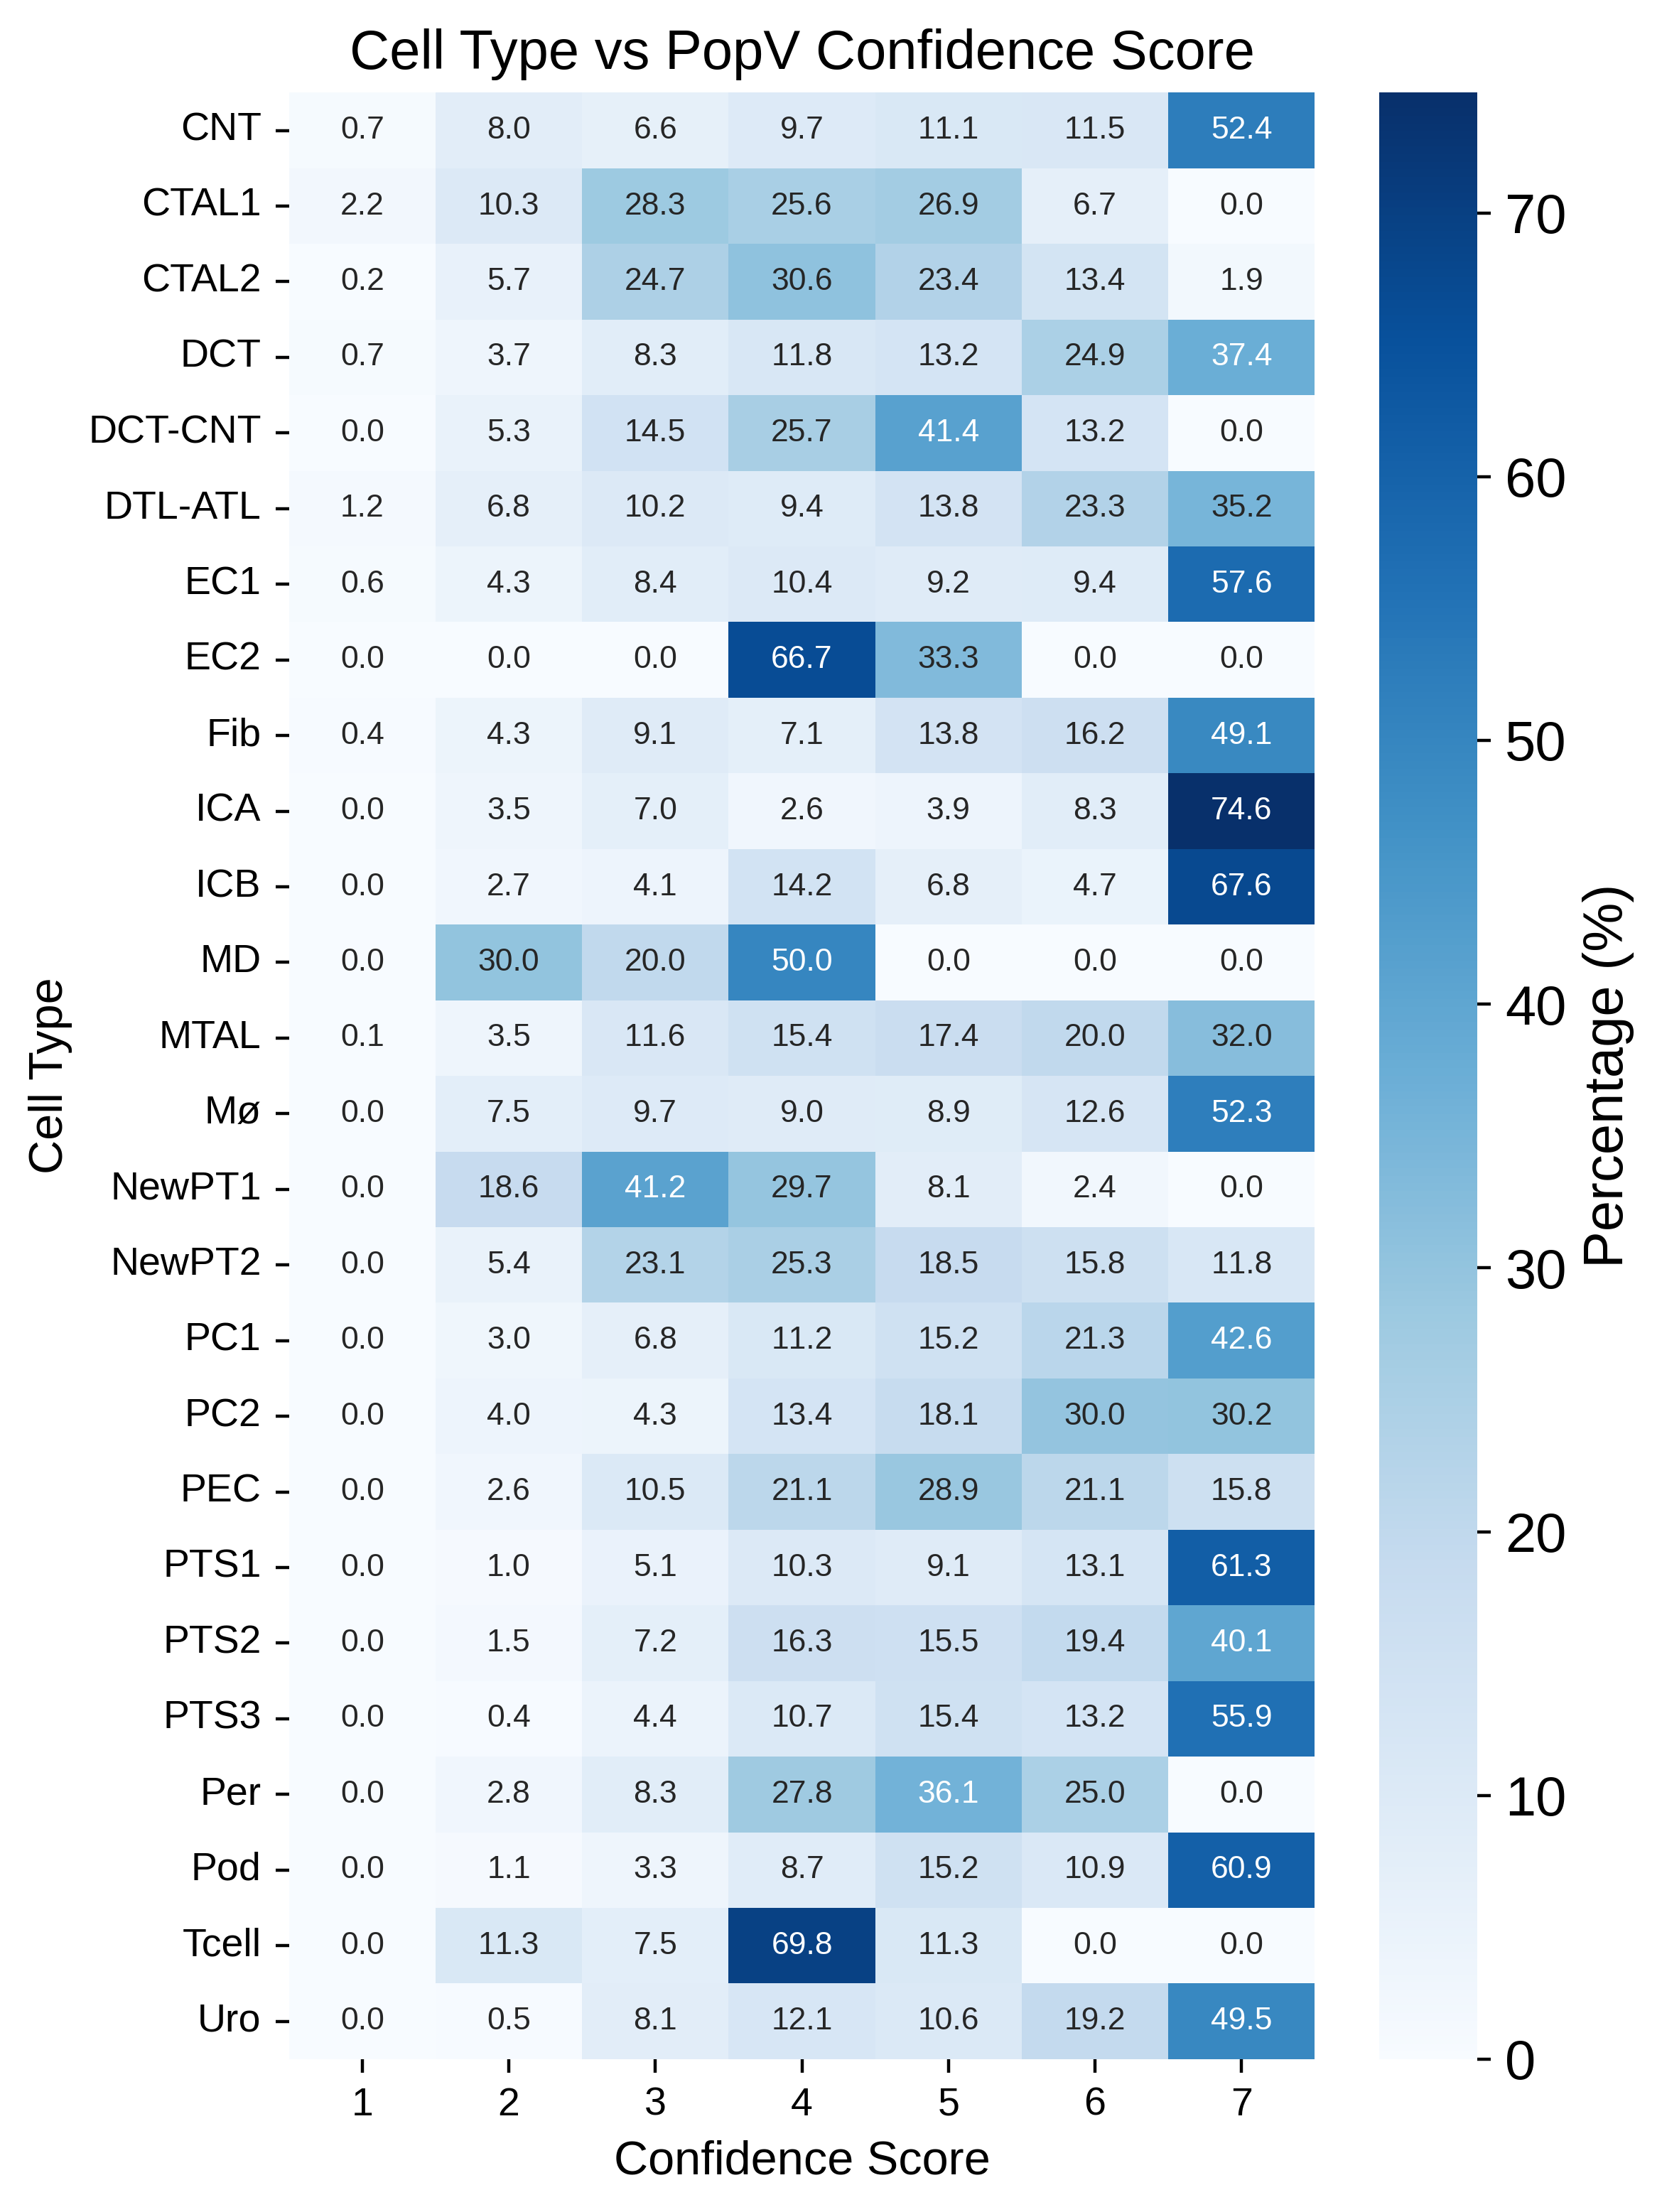

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Convert score to numeric if not already
query_results.obs["popv_majority_vote_score"] = query_results.obs["popv_majority_vote_score"].astype(int)

# Create crosstab with row percentages
crosstab_pct = pd.crosstab(
    query_results.obs["popv_majority_vote_prediction"], 
    query_results.obs["popv_majority_vote_score"],
    normalize='index'
) * 100

# print(crosstab_pct.round(1))

fig, ax = plt.subplots(figsize=(6, 8))
sns.heatmap(crosstab_pct, 
            annot=True, 
            fmt='.1f', 
            cmap='Blues', 
            ax=ax,
            linewidths=0,
            linecolor='none',
            annot_kws={'size': 8},  # Font size for numbers
            cbar_kws={'label': 'Percentage (%)'})
ax.set_xlabel("Confidence Score", fontsize=12)
ax.set_ylabel("Cell Type", fontsize=12)
ax.set_title("Cell Type vs PopV Confidence Score", fontsize=14)
ax.tick_params(axis='both', labelsize=10)  # Axis tick label size

# Remove any remaining grid lines
ax.grid(False)

plt.tight_layout()
# plt.savefig("celltype_score_heatmap_percent.png", dpi=150)
plt.show()

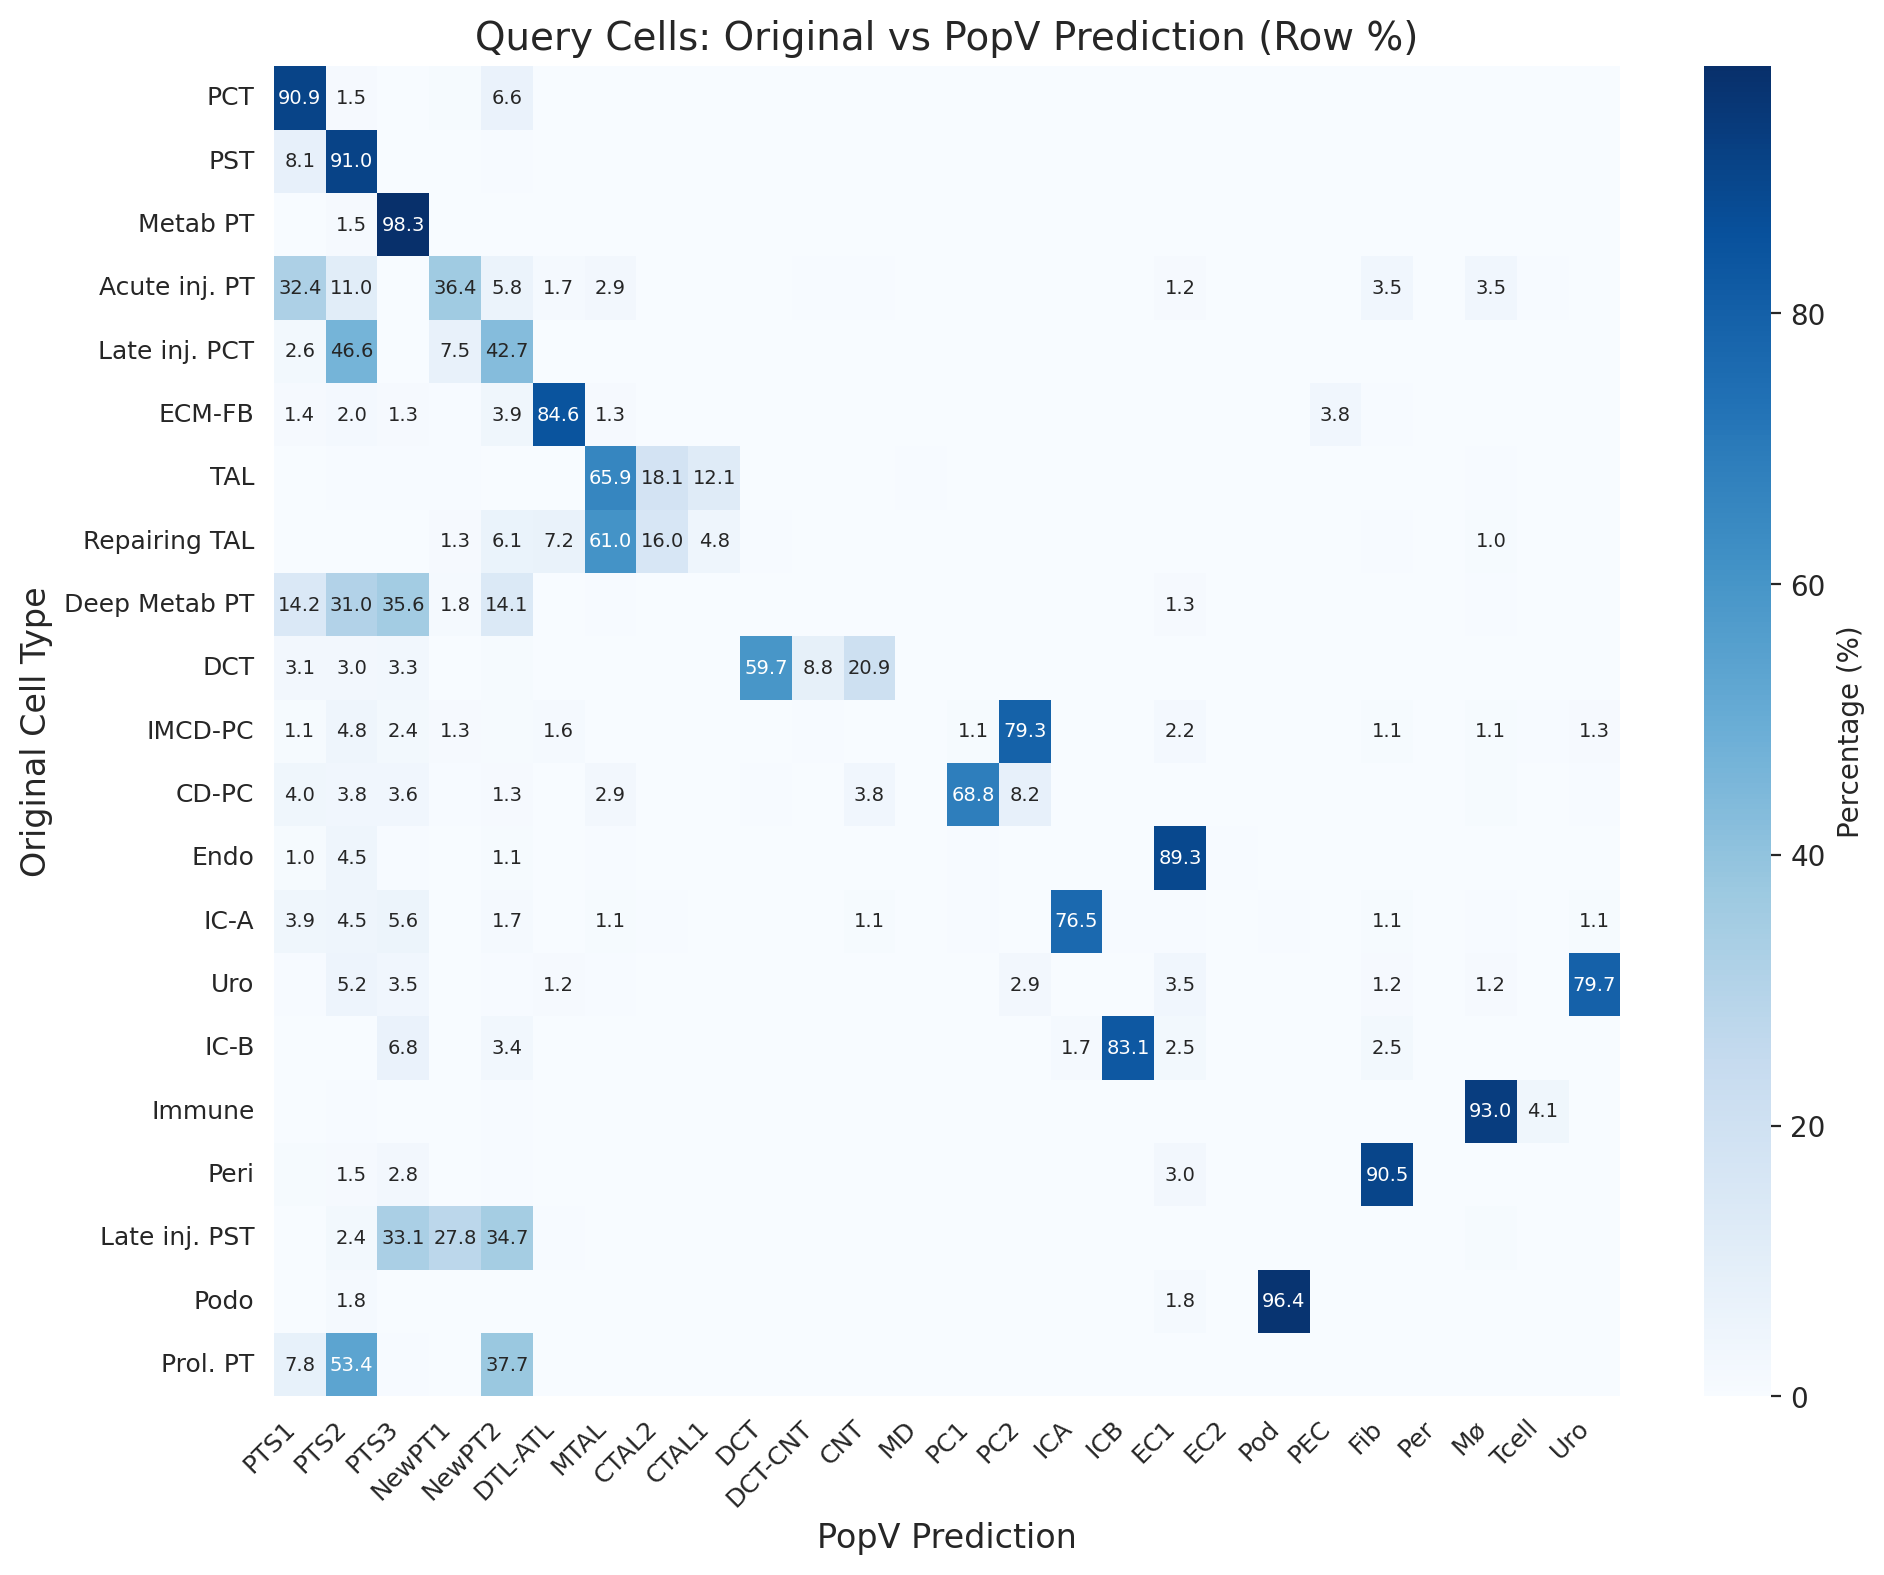

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Reset style
plt.style.use('default')
sns.set_style("white")

# Define column order
celltype_groups = {
    'Proximal Tubule': ['PTS1', 'PTS2', 'PTS3', 'NewPT1', 'NewPT2'],
    'Loop of Henle': ['DTL-ATL', 'MTAL', 'CTAL2', 'CTAL1'],
    'Distal Tubule': ['DCT', 'DCT-CNT', 'CNT', 'MD'],
    'Collecting Duct': ['PC1', 'PC2', 'ICA', 'ICB'],
    'Endothelial': ['EC1', 'EC2'],
    'Glomerular': ['Pod', 'PEC'],
    'Stromal': ['Fib', 'Per'],
    'Immune': ['Mø', 'Tcell'],
    'Other': ['Uro']
}

# Flatten to get column order
col_order = [ct for group in celltype_groups.values() for ct in group]

# Create confusion matrix for query cells
confusion = pd.crosstab(
    query_results.obs["celltype"],
    query_results.obs["popv_majority_vote_prediction"],
    normalize='index'
) * 100

# Filter col_order to only include columns that exist in confusion matrix
col_order = [c for c in col_order if c in confusion.columns]

# Add any columns not in the predefined order
remaining_cols = [c for c in confusion.columns if c not in col_order]
col_order.extend(remaining_cols)

# Reorder columns
confusion_ordered = confusion[col_order]

# Reorder rows: for each column, find the row with max value (greedy)
row_order = []
remaining_rows = list(confusion_ordered.index)

for col in col_order:
    if remaining_rows:
        # Find which remaining row has max value in this column
        max_row = confusion_ordered.loc[remaining_rows, col].idxmax()
        row_order.append(max_row)
        remaining_rows.remove(max_row)

# Add any remaining rows
row_order.extend(remaining_rows)

# Reorder both rows and columns
confusion_ordered = confusion_ordered.loc[row_order, col_order]

# Create annotation matrix - hide values < 1%
annot = confusion_ordered.copy()
annot = annot.applymap(lambda x: f'{x:.1f}' if x >= 1 else '')

# Heatmap
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(confusion_ordered, 
            annot=annot,
            fmt='',
            cmap='Blues', 
            ax=ax,
            linewidths=0,
            annot_kws={'size': 7},
            cbar_kws={'label': 'Percentage (%)'})
ax.set_xlabel("PopV Prediction", fontsize=12)
ax.set_ylabel("Original Cell Type", fontsize=12)
ax.set_title("Query Cells: Original vs PopV Prediction (Row %)", fontsize=14)
ax.tick_params(axis='both', labelsize=9)

# Rotate x-axis labels for readability
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

plt.tight_layout()
# plt.savefig("query_celltype_confusion_matrix_ordered.png", dpi=150)
plt.show()

# Save to CSV
# confusion_ordered.to_csv("query_celltype_confusion_matrix_ordered.csv")

In [ ]:
# =============================================================================
# 7. Save results
# =============================================================================
# Save full annotated object
# adata.write_h5ad("popv_annotated_full.h5ad")

# Save query results only
# query_results.write_h5ad("popv_annotated_query.h5ad")

# Export predictions to CSV
# query_results.obs[[
#     "popv_majority_vote_prediction",
#     "popv_majority_vote_score"
# ]].to_csv("popv_predictions.csv")

# =============================================================================
# 8. Visualize results (optional)
# =============================================================================
# import matplotlib.pyplot as plt

# # UMAP colored by predictions
# sc.pl.umap(query_results, color=["popv_majority_vote_prediction"], 
#            title="PopV Cell Type Predictions")
# sc.pl.umap(query_results, color=["popv_majority_vote_score"], 
#            title="PopV Confidence Score", cmap="viridis")

# # Confidence distribution
# fig, ax = plt.subplots(figsize=(8, 5))
# query_results.obs["popv_majority_vote_score"].value_counts().sort_index().plot(kind='bar', ax=ax)
# ax.set_xlabel("Number of methods agreeing")
# ax.set_ylabel("Number of cells")
# ax.set_title("PopV Confidence Distribution")
# plt.tight_layout()
# plt.savefig("popv_confidence_distribution.png", dpi=150)
# plt.show()

# =============================================================================
# 9. Filter by confidence (optional)
# =============================================================================
# # High confidence: 6+ methods agree
# high_conf = query_results[query_results.obs["popv_majority_vote_score"] >= 6].copy()
# print(f"\nHigh confidence cells: {high_conf.n_obs}")

# # Low confidence: fewer than 4 methods agree (may need manual review)
# low_conf = query_results[query_results.obs["popv_majority_vote_score"] < 4].copy()
# print(f"Low confidence cells (review these): {low_conf.n_obs}")